In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.719,1.390,2.062,1.980,1.975,1.896,1.928,1.882,1.568,1.227,1.828,1.575,2.338,1.326,2.126,NaN,1.335,1.136,1.808,1.173,2.097,NaN,1.748,NaN,1.230,0.887,1.954,1.554,1.663,1.130,2.058,NaN,1.344,1.077,2.016,1.678,NaN,1.378,NaN,2.238,1.398
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.250,1.411,2.094,1.990,2.005,1.902,1.947,1.916,1.545,1.233,1.853,1.580,2.326,1.287,2.111,NaN,1.302,1.203,1.905,1.257,2.096,NaN,1.731,NaN,1.225,0.892,1.990,1.585,1.758,1.171,2.085,NaN,1.316,1.081,2.076,1.723,NaN,1.399,NaN,2.277,1.375
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.685,0.425,0.468,0.103,0.818,0.243,0.401,-0.257,0.243,1.233,1.237,1.110,0.390,1.633,-0.085,NaN,0.645,-0.110,1.016,1.521,0.093,NaN,0.667,NaN,0.481,1.145,0.696,0.963,0.973,1.262,0.080,NaN,0.440,1.584,1.169,0.821,NaN,1.323,NaN,-0.209,0.514
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.737,0.535,0.650,0.311,1.004,0.355,0.423,-0.260,0.293,1.239,1.420,1.261,0.485,1.719,-0.043,NaN,0.644,0.063,1.342,1.911,0.083,NaN,0.660,NaN,0.581,1.136,0.829,1.091,1.118,1.327,-0.002,NaN,0.463,1.607,1.408,1.054,NaN,1.488,NaN,-0.181,0.539
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.147,-0.905,-0.808,-0.649,-0.051,-0.960,-1.142,-1.254,-0.986,-0.986,-0.688,-0.744,-0.454,-0.600,-1.121,NaN,-1.136,-1.086,-0.706,-0.376,-0.965,NaN,-1.311,NaN,-1.033,-0.986,-0.944,-0.738,-0.269,-0.997,-1.182,NaN,-0.956,-1.133,-0.800,-0.735,NaN,-0.756,NaN,-1.374,-1.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.340,2.772,2.077,2.699,2.173,2.724,2.559,1.704,2.190,2.655,1.838,2.159,1.572,2.181,NaN,1.503,3.214,3.521,2.520,2.442,NaN,1.579,NaN,2.171,2.152,3.157,2.291,3.047,1.898,2.714,NaN,1.411,2.389,3.121,2.806,NaN,2.094,NaN,2.726,1.675
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.442,-0.692,-0.653,-0.289,-0.518,-0.454,-0.900,-0.701,-0.476,-0.811,-0.623,-0.503,-0.229,-0.569,NaN,-0.662,0.435,-0.592,-0.613,-0.740,NaN,-0.422,NaN,-0.401,-0.583,-0.885,-0.778,-0.403,-0.969,-0.667,NaN,-0.700,-0.395,-0.853,-0.732,NaN,-0.705,NaN,-0.555,-0.637
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.026,-0.156,0.190,0.085,0.238,0.346,-0.599,-0.131,0.557,0.220,0.750,-0.166,1.155,-0.130,NaN,0.258,0.585,0.190,1.309,-0.005,NaN,0.694,NaN,0.312,0.870,0.181,0.972,-0.029,1.078,-0.083,NaN,0.099,1.263,0.912,1.407,NaN,1.855,NaN,0.355,0.310
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.131,-0.177,-0.151,

In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 78990
diff 38034
const 722645


In [5]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

# y_pred = np.load(f'../saved/0422_GosaiMPRA_MyResTransformer3_seq/0421_122831/Gosai_MPRA_pred.npy')


# y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/Gosai_MPRA_pred.npy')
y_pred = np.load(f'../saved/0612_Gosai_MPRA_MyResTransformer_seq_epi_3_cell_types/0611_230252/Gosai_MPRA_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [6]:
data_split = 'test'
cond_0 = data_split_dict[data_split]
df = MPRA_df.loc[cond_0]

x = df['HepG2_pred'] - df['K562_pred']
y = df['HepG2'] - df['K562']

r = pearson(x, y)
print(r)

x = df['HepG2_DNase'] - df['K562_DNase']
y = df['HepG2'] - df['K562']

r = pearson(x, y)
print(r)




x = df['HCT116_pred'] - df['K562_pred']
y = df['HCT116'] - df['K562']

r = pearson(x, y)
print(r)

x = df['HCT116_DNase'] - df['K562_DNase']
y = df['HCT116'] - df['K562']

r = pearson(x, y)
print(r)






x = df['A549_pred'] - df['K562_pred']
y = df['A549'] - df['K562']

r = pearson(x, y)
print(r)

x = df['A549_DNase'] - df['K562_DNase']
y = df['A549'] - df['K562']

r = pearson(x, y)
print(r)

(0.48281510595574445, 0.0)
(0.302433613671545, 0.0)
(0.26388107103257763, 0.0)
(0.25988386905631455, 0.0)
(0.3615254735253103, 0.0)
(0.2688774636197617, 0.0)


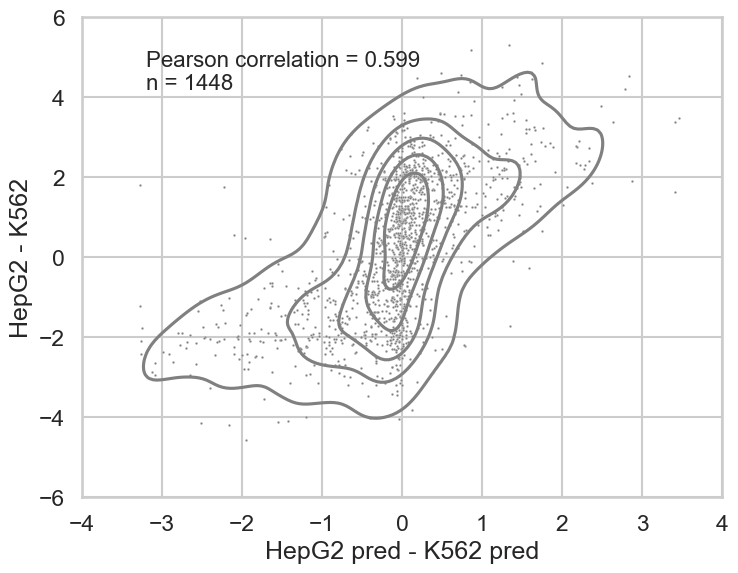

In [37]:
cond_0 = data_split_dict['test+diff']
df = MPRA_df.loc[cond_0]

sns.set_theme('talk', 'whitegrid')
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = df['HepG2_pred'] - df['K562_pred']
y = df['HepG2'] - df['K562']
scatter = sns.scatterplot(x=x, y=y, s=3, color='gray')
kde = sns.kdeplot(x=x, y=y, color='gray', levels=6)

r = pearson(x, y)[0]
plt.text(
    x=0.1, y=0.85, transform=scatter.transAxes, fontsize=16,
    s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', 
)


plt.xlabel('HepG2 pred - K562 pred')
plt.ylabel('HepG2 - K562')
plt.xlim([-4, 4])
plt.ylim([-6, 6])
plt.savefig('figures/Gosai_MPRA_HepG2-K562_scatter.png', dpi=400)
plt.show()

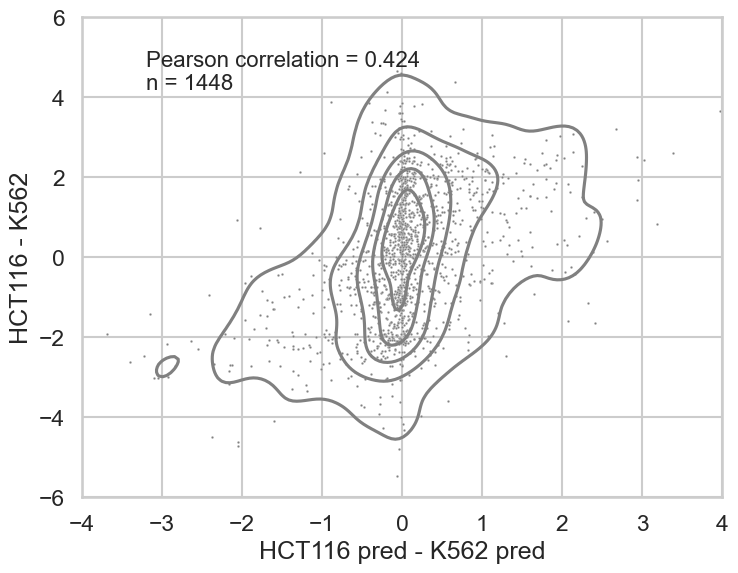

In [38]:
cond_0 = data_split_dict['test+diff']
df = MPRA_df.loc[cond_0]

sns.set_theme('talk', 'whitegrid')
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = df['HCT116_pred'] - df['K562_pred']
y = df['HCT116'] - df['K562']
scatter = sns.scatterplot(x=x, y=y, s=3, color='gray')
kde = sns.kdeplot(x=x, y=y, color='gray', levels=6)

r = pearson(x, y)[0]
plt.text(
    x=0.1, y=0.85, transform=scatter.transAxes, fontsize=16,
    s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', 
)


plt.xlabel('HCT116 pred - K562 pred')
plt.ylabel('HCT116 - K562')
plt.xlim([-4, 4])
plt.ylim([-6, 6])
plt.savefig('figures/Gosai_MPRA_HCT116-K562_scatter.png', dpi=400)
plt.show()

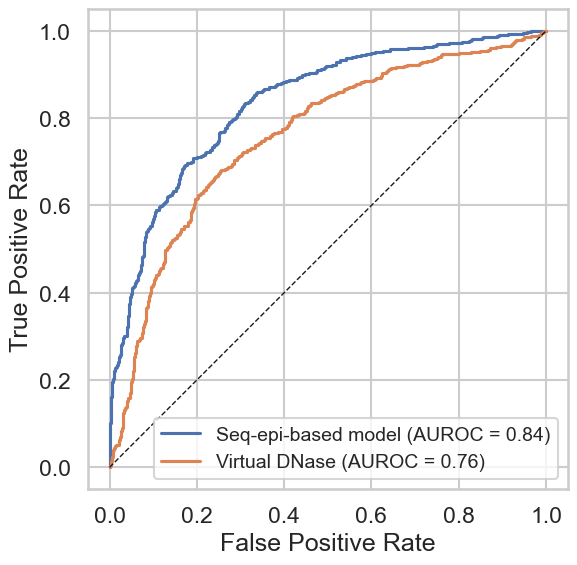

In [39]:
# 正类是 HCT116 > 1,  负类是 HCT116 < 1

from sklearn.metrics import roc_curve, auc

cond_0 = data_split_dict['test+diff']
cond_1 = MPRA_df['HCT116'].notna()
df = MPRA_df.loc[cond_0 & cond_1]


plt.figure(figsize=(6, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)


y_true_pos = (df['HCT116']) > 1
y_score_pos = df['HCT116_pred']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)

plt.plot(fpr_pos, tpr_pos, label=f'Seq-epi-based model (AUROC = {auc_pos:.2f})')



y_true_pos = (df['HCT116']) > 1
y_score_pos = df['HCT116_DNase']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)

plt.plot(fpr_pos, tpr_pos, label=f'Virtual DNase (AUROC = {auc_pos:.2f})')




plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(fontsize=14)
plt.axis('square')
plt.savefig('figures/Gosai_MPRA_AUROC_HCT116.png', dpi=400)
plt.show()

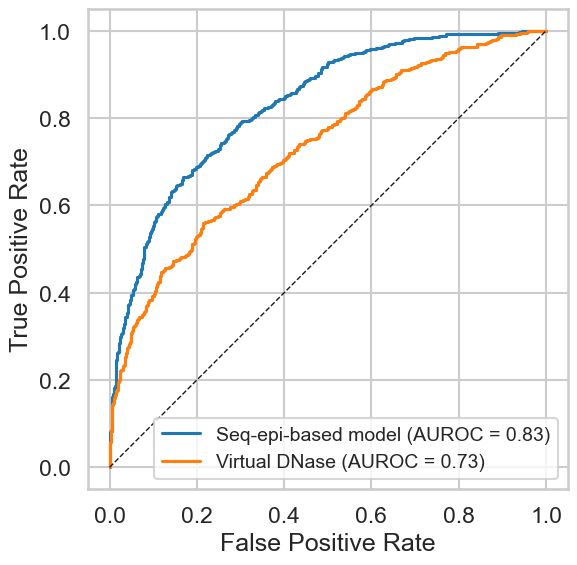

In [52]:
# 正类是 HCT116 - HepG2 > 1,  负类是 HCT116 - HepG2 < -1

from sklearn.metrics import roc_curve, auc

cond_0 = data_split_dict['test+diff']
cond_1 = MPRA_df['HepG2'].notna()
# cond_2 = ((MPRA_df['HCT116'] - MPRA_df['K562']).abs() > 1)
df = MPRA_df.loc[cond_0 & cond_1]

plt.figure(figsize=(6, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

y_true_pos = (df['HepG2'] - df['K562']) > 0
y_score_pos = df['HepG2_pred'] - df['K562_pred']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)
plt.plot(fpr_pos, tpr_pos, label=f'Seq-epi-based model (AUROC = {auc_pos:.2f})', color=tab20_colors[0])


# y_true_pos = (df['HCT116'] - df['K562']) > 0
# y_score_pos = df['HepG2_seq_pred'] - df['K562_seq_pred']
# fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
# auc_pos = auc(fpr_pos, tpr_pos)
# plt.plot(fpr_pos, tpr_pos, label=f'Seq-based model (AUROC = {auc_pos:.2f})')



y_true_pos = (df['HepG2'] - df['K562']) > 0
y_score_pos = df['HepG2_DNase'] - df['K562_DNase']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)
plt.plot(fpr_pos, tpr_pos, label=f'Virtual DNase (AUROC = {auc_pos:.2f})', color=tab20_colors[2])




# y_true_pos = (df['HepG2'] - df['K562']) > 0
# y_score_pos = df['HepG2_H3K4me3'] - df['K562_H3K4me3']
# fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
# auc_pos = auc(fpr_pos, tpr_pos)
# plt.plot(fpr_pos, tpr_pos, label=f'Virtual H3K4me3 (AUROC = {auc_pos:.2f})', color=tab20_colors[4])



plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(fontsize=14)
plt.axis('square')
plt.savefig('figures/Gosai_MPRA_AUROC_HepG2-K562.png', dpi=400)
plt.show()

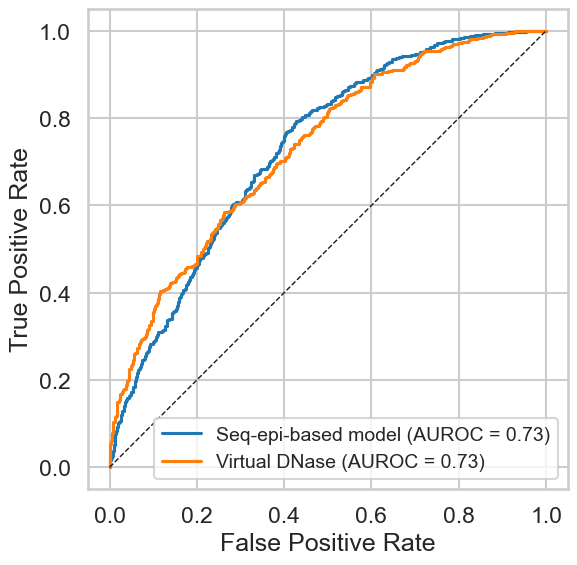

In [51]:
# 正类是 HCT116 - HepG2 > 1,  负类是 HCT116 - HepG2 < -1

from sklearn.metrics import roc_curve, auc

cond_0 = data_split_dict['test+diff']
cond_1 = MPRA_df['HCT116'].notna()
# cond_2 = ((MPRA_df['HCT116'] - MPRA_df['K562']).abs() > 1)
df = MPRA_df.loc[cond_0 & cond_1]

plt.figure(figsize=(6, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

y_true_pos = (df['HCT116'] - df['K562']) > 0
y_score_pos = df['HCT116_pred'] - df['K562_pred']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)
plt.plot(fpr_pos, tpr_pos, label=f'Seq-epi-based model (AUROC = {auc_pos:.2f})', color=tab20_colors[0])



y_true_pos = (df['HCT116'] - df['K562']) > 0
y_score_pos = df['HCT116_DNase'] - df['K562_DNase']
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)
plt.plot(fpr_pos, tpr_pos, label=f'Virtual DNase (AUROC = {auc_pos:.2f})', color=tab20_colors[2])




# y_true_pos = (df['HCT116'] - df['K562']) > 0
# y_score_pos = df['HCT116_H3K4me3'] - df['K562_H3K4me3']
# fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
# auc_pos = auc(fpr_pos, tpr_pos)
# plt.plot(fpr_pos, tpr_pos, label=f'Virtual H3K4me3 (AUROC = {auc_pos:.2f})', color=tab20_colors[4])



plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(fontsize=14)
plt.axis('square')
plt.savefig('figures/Gosai_MPRA_AUROC_HCT116-K562.png', dpi=400)
plt.show()

In [53]:
# MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

# data_split = 'test'
# cond_0 = data_split_dict[data_split]
# cond_1 = MPRA_df['HCT116'].notna()

# df = MPRA_df.loc[cond_0 & cond_1]



# target = df['HCT116']
# pred = df['HCT116_pred']


# plt.figure(figsize=(8,6), dpi=100)
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# sns.histplot(target, binwidth=1e-1, stat='density', alpha=0.5, label='All sequences', kde=True)

# threshold = np.percentile(pred, 80)
# target_0 = target[pred > threshold]
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

# threshold = np.percentile(pred, 95)
# target_0 = target[pred > threshold]
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

# threshold = np.percentile(pred, 99)
# target_0 = target[pred > threshold]
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)


# plt.xlim(-4, 8)
# plt.ylim(0, 1)
# plt.xlabel('HCT116 activity')
# plt.ylabel('Density')
# plt.legend()
# plt.savefig('figures/Gosai_MPRA_HCT116_sequence_prioritization.png', dpi=400)

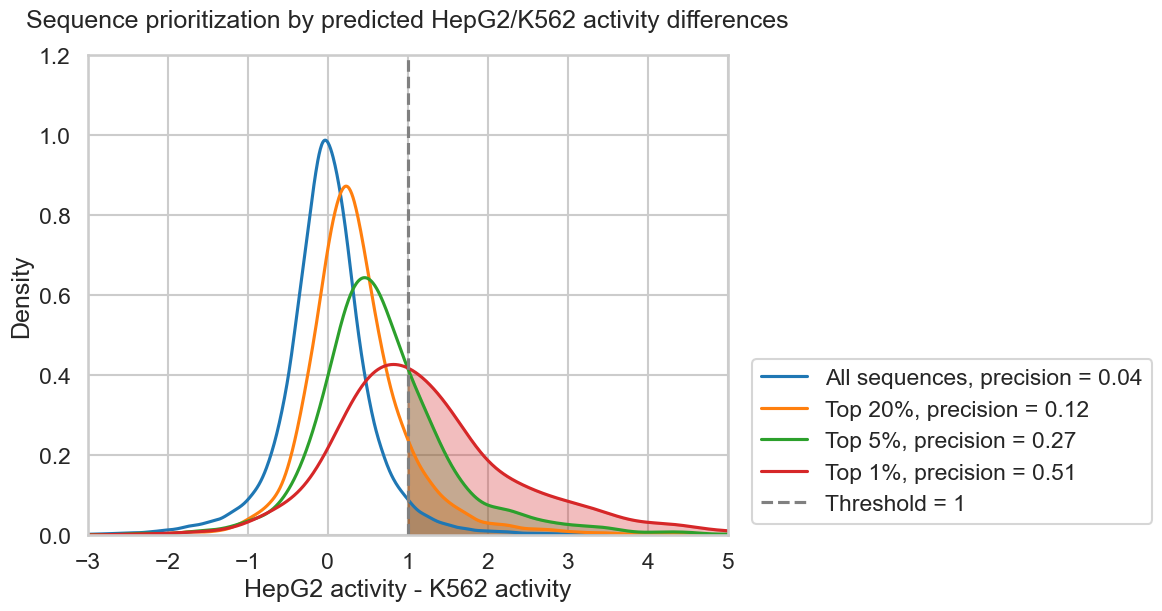

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

cond_0 = data_split_dict['test']
cond_1 = MPRA_df['HepG2'].notna()
df = MPRA_df.loc[cond_0 & cond_1]

target = df['HepG2'] - df['K562']
pred = df['HepG2_pred'] - df['K562_pred']

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

def plot_kde_with_shading(data, label_prefix, color):
    precision = (data > 1).sum() / len(data)
    label = f'{label_prefix}, precision = {precision:.2f}'

    # KDE 曲线
    kde = gaussian_kde(data)
    x_vals = np.linspace(-3, 5, 1000)
    y_vals = kde(x_vals)
    plt.plot(x_vals, y_vals, label=label, color=color)

    # 填充 x > 1 的部分
    mask = x_vals > 1
    plt.fill_between(x_vals[mask], y_vals[mask], alpha=0.3, color=color)

# 全部序列
plot_kde_with_shading(target, 'All sequences', color=tab20_colors[0])

# Top 20%
threshold = np.percentile(pred, 80)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 20%', color=tab20_colors[2])

# Top 5%
threshold = np.percentile(pred, 95)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 5%', color=tab20_colors[4])

# Top 1%
threshold = np.percentile(pred, 99)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 1%', color=tab20_colors[6])

# 添加虚线
plt.axvline(x=1, color='gray', linestyle='--', label='Threshold = 1')

# 美化图像
plt.xlim(-3, 5)
plt.ylim(0, 1.2)
plt.xlabel('HepG2 activity - K562 activity')
plt.ylabel('Density')
plt.title('Sequence prioritization by predicted HepG2/K562 activity differences', pad=20)
plt.legend(bbox_to_anchor=(1.02, 0), loc='lower left')
plt.savefig('figures/Gosai_MPRA_sequence_prioritization_HepG2-K562.png', dpi=400, bbox_inches='tight')

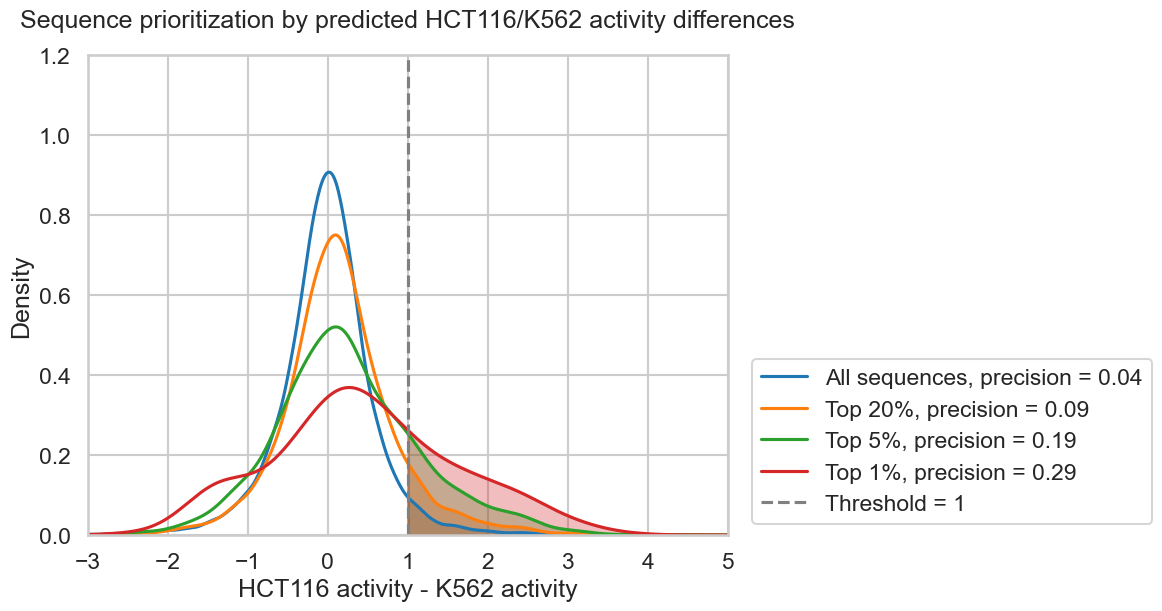

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

cond_0 = data_split_dict['test']
cond_1 = MPRA_df['HCT116'].notna()
df = MPRA_df.loc[cond_0 & cond_1]

target = df['HCT116'] - df['K562']
pred = df['HCT116_pred'] - df['K562_pred']

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

def plot_kde_with_shading(data, label_prefix, color):
    precision = (data > 1).sum() / len(data)
    label = f'{label_prefix}, precision = {precision:.2f}'

    # KDE 曲线
    kde = gaussian_kde(data)
    x_vals = np.linspace(-3, 5, 1000)
    y_vals = kde(x_vals)
    plt.plot(x_vals, y_vals, label=label, color=color)

    # 填充 x > 1 的部分
    mask = x_vals > 1
    plt.fill_between(x_vals[mask], y_vals[mask], alpha=0.3, color=color)

# 全部序列
plot_kde_with_shading(target, 'All sequences', color=tab20_colors[0])

# Top 20%
threshold = np.percentile(pred, 80)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 20%', color=tab20_colors[2])

# Top 5%
threshold = np.percentile(pred, 95)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 5%', color=tab20_colors[4])

# Top 1%
threshold = np.percentile(pred, 99)
target_0 = target[pred > threshold]
plot_kde_with_shading(target_0, 'Top 1%', color=tab20_colors[6])

# 添加虚线
plt.axvline(x=1, color='gray', linestyle='--', label='Threshold = 1')

# 美化图像
plt.xlim(-3, 5)
plt.ylim(0, 1.2)
plt.xlabel('HCT116 activity - K562 activity')
plt.ylabel('Density')
plt.title('Sequence prioritization by predicted HCT116/K562 activity differences', pad=20)
plt.legend(bbox_to_anchor=(1.02, 0), loc='lower left')
plt.savefig('figures/Gosai_MPRA_sequence_prioritization_HCT116-K562.png', dpi=400, bbox_inches='tight')


In [19]:
# cond_0 = data_split_dict['test']
# cond_1 = MPRA_df['HepG2'].notna()
# df = MPRA_df.loc[cond_0 & cond_1]

# target = df['HepG2'] - df['K562']
# pred = df['HepG2_pred'] - df['K562_pred']
# #######MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']
# #######这里我应该假设已知K562活性吗？


# plt.figure(figsize=(8,6), dpi=100)
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# precision = (target > 1).sum() / len(target)
# sns.histplot(target, binwidth=1e-1, stat='density', alpha=0.5, label=f'All sequences, precision = {precision:.2f}', kde=True, color=tab20_colors[0])

# threshold = np.percentile(pred, 80)
# target_0 = target[pred > threshold]
# precision = (target_0 > 1).sum() / len(target_0)
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 20%, precision = {precision:.2f}', kde=True, color=tab20_colors[2])

# threshold = np.percentile(pred, 95)
# target_0 = target[pred > threshold]
# precision = (target_0 > 1).sum() / len(target_0)
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 5%, precision = {precision:.2f}', kde=True, color=tab20_colors[4])

# threshold = np.percentile(pred, 99)
# target_0 = target[pred > threshold]
# precision = (target_0 > 1).sum() / len(target_0)
# sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 1%, precision = {precision:.2f}', kde=True, color=tab20_colors[6])

# plt.axvline(x=1, color='gray', linestyle='--', label='Threshold = 1')

# plt.xlim(-3, 5)
# plt.ylim(0, 2)
# plt.xlabel('HepG2 activity - K562 activity')
# plt.ylabel('Density')
# plt.legend()
# plt.savefig('figures/Gosai_MPRA_HepG2-K562_sequence_prioritization.png', dpi=400)

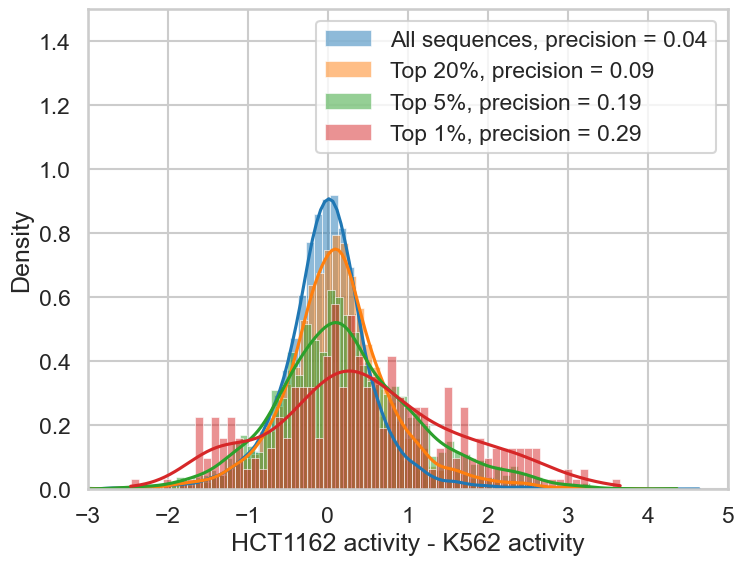

In [68]:
cond_0 = data_split_dict['test']
cond_1 = MPRA_df['HCT116'].notna()
df = MPRA_df.loc[cond_0 & cond_1]

target = df['HCT116'] - df['K562']
pred = df['HCT116_pred'] - df['K562_pred']
#######MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']
#######这里我应该假设已知K562活性吗？


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

precision = (target > 1).sum() / len(target)
sns.histplot(target, binwidth=1e-1, stat='density', alpha=0.5, label=f'All sequences, precision = {precision:.2f}', kde=True, color=tab20_colors[0])

threshold = np.percentile(pred, 80)
target_0 = target[pred > threshold]
precision = (target_0 > 1).sum() / len(target_0)
sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 20%, precision = {precision:.2f}', kde=True, color=tab20_colors[2])

threshold = np.percentile(pred, 95)
target_0 = target[pred > threshold]
precision = (target_0 > 1).sum() / len(target_0)
sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 5%, precision = {precision:.2f}', kde=True, color=tab20_colors[4])

threshold = np.percentile(pred, 99)
target_0 = target[pred > threshold]
precision = (target_0 > 1).sum() / len(target_0)
sns.histplot(target_0, binwidth=1e-1, stat='density', alpha=0.5, label=f'Top 1%, precision = {precision:.2f}', kde=True, color=tab20_colors[6])


plt.xlim(-3, 5)
plt.ylim(0, 1.5)
plt.xlabel('HCT1162 activity - K562 activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116-K562_sequence_prioritization.png', dpi=400)

0.3234896766747432


/tmp/ipykernel_50603/1721555110.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MPRA_df[cond]


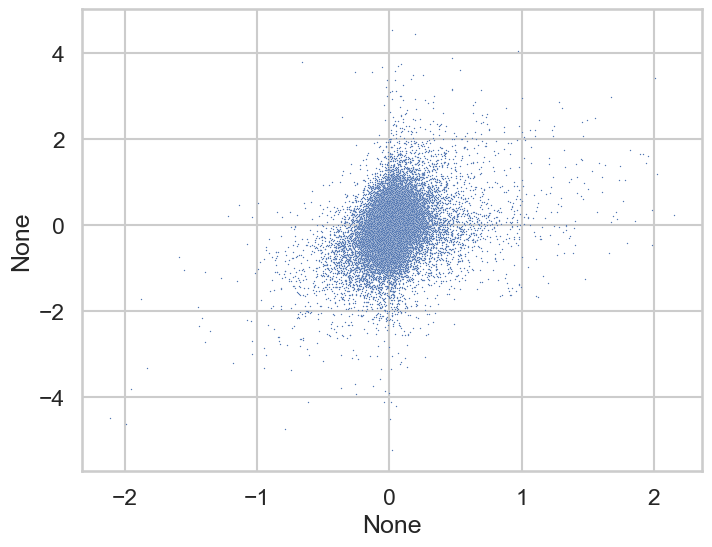

In [42]:
cond = data_split_dict['test']
df = MPRA_df[cond]
x = df['HCT116_pred'] - df['K562_pred']
y = df['HCT116'] - df['K562']

sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)

0.26864384253401513


/tmp/ipykernel_50603/1007104473.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MPRA_df[cond]


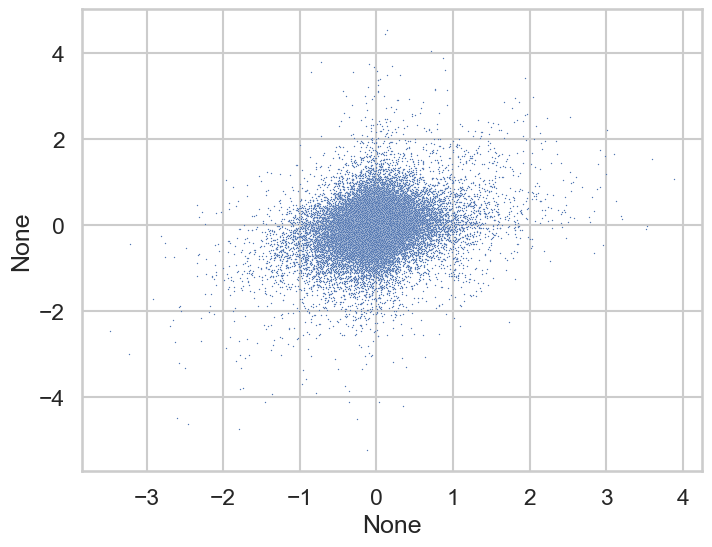

In [44]:
cond = data_split_dict['test']
df = MPRA_df[cond]
x = df['HCT116_DNase'] - df['K562_DNase']
y = df['HCT116'] - df['K562']

sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)